In [ ]:
# ! pip install datasets tnkeeh -qU
# ! pip install arabic-reshaper -qU
# ! pip install python-bidi -qU
# ! pip install wordcloud -qU
# ! pip install Arabic-Stopwords==0.4.3 -qU
# ! pip install -q diff-match-patch==20230430
# ! pip install camel-tools -qU
# ! pip install textacy==0.13.0  -qU
# ! camel_data -i all
# ! pip install pyspark -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import load_dataset,DatasetDict,Dataset
import tnkeeh as tn
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import sample
from statistics import stdev,mean
import random
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
import arabicstopwords.arabicstopwords as stp
from diff_match_patch import diff_match_patch
from IPython.core.display import display, HTML
from textacy import preprocessing
from functools import partial
from camel_tools.tokenizers.word import simple_word_tokenize
from tqdm import tqdm
from collections import Counter
from google.colab import userdata
from string import punctuation
import concurrent.futures
# pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# For arabic specific processing
from camel_tools.utils.normalize import (normalize_alef_ar,
                                         normalize_alef_maksura_ar,
                                         normalize_teh_marbuta_ar,
                                         normalize_unicode)
from camel_tools.utils.dediac import dediac_ar
from camel_tools.morphology.database import MorphologyDB
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer
from camel_tools.tagger.default import DefaultTagger



In [ ]:
ds_path ="ahmedelsayed/xlsum-arabic"
ds = load_dataset(path=ds_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/578 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/92.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37516 [00:00<?, ? examples/s]

In [ ]:
ds

In [ ]:
cleaner = tn.Tnkeeh(remove_diacritics = True,
                    normalize=True,
                    remove_html_elements=True,
                    remove_links=True,
                    remove_tatweel=True,
                    remove_twitter_meta=True,)


cleaner2 = preprocessing.make_pipeline(
    # arabic specific processing
    normalize_alef_ar,
    normalize_alef_maksura_ar,
    normalize_unicode,
    normalize_teh_marbuta_ar,
    dediac_ar,
    # general processing
    preprocessing.remove.html_tags,
    preprocessing.remove.brackets,
    partial(preprocessing.replace.urls,repl=''),
    partial(preprocessing.replace.emails,repl=''),
    partial(preprocessing.replace.hashtags,repl=''),
    partial(preprocessing.replace.phone_numbers,repl=''),
    partial(preprocessing.replace.urls,repl=''),
    preprocessing.normalize.unicode,
    preprocessing.normalize.whitespace
)

# 1. Cleaning

In [ ]:
def clean_hf_dataset_with_tnkeeh_cleaner(ds,cleaner):
    meta_data = ds.column_names
    cleaned_ds = DatasetDict()
    for split,col_names in meta_data.items():
        initial_ds = ds[split]
        for col in col_names:
            initial_ds = cleaner.clean_hf_dataset(initial_ds,field=col)
        cleaned_ds[split] = initial_ds

    return cleaned_ds



def clean_hf_dataset_with_custom_cleaner(ds,cleaner):
    meta_data = ds.column_names
    cleaned_ds = DatasetDict()
    for split,col_names in meta_data.items():
        initial_df = ds[split].to_pandas()
        for col in col_names:
            initial_df.loc[:,col] = initial_df[col].apply(cleaner)
        cleaned_ds[split] = Dataset.from_pandas(initial_df)

    return cleaned_ds

In [ ]:
# cleaned_data = clean_hf_dataset_with_tnkeeh_cleaner(ds,cleaner)
cleaned_data = clean_hf_dataset_with_custom_cleaner(ds,cleaner2)

### Push to HF

In [ ]:
hf_token = userdata.get('hf')
cleaned_data.push_to_hub(token=hf_token,
                         repo_id=ds_path,
                         data_dir='Cleaned-Camel',
                         commit_message="[Feat]: cleaned version using CAMel tools")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/38 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ahmedelsayed/xlsum-arabic/commit/b3c67b631efe28af59448a19645d490f0292862f', commit_message='[Feat]: cleaned version using CAMel tools', commit_description='', oid='b3c67b631efe28af59448a19645d490f0292862f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
data_dir = 'Cleaned-Camel'
repo_id="ahmedelsayed/xlsum-arabic"
cleaned_data = load_dataset(path=repo_id,
                            data_dir=data_dir)

README.md:   0%|          | 0.00/599 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.1M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37516 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4689 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4689 [00:00<?, ? examples/s]

# 2. Analysis

In [ ]:
def get_lengths(docs):
    arr_lenghts = [len(doc.split()) for doc in docs]
    return arr_lenghts

## 2.1 Length based analysis

In [ ]:
def get_length_stat_from_hf_dataset(ds):
    meta_data = ds.column_names
    stats = {}
    for split,col_names in meta_data.items():
        data = {}
        print(f"Processing {split}:")
        for col in tqdm(col_names,desc="Processing Columns"):
            lenghts= get_lengths(docs=ds[split][col])
            data.update({col:lenghts})
        stats.update({split:data})
    return stats

In [ ]:
stats = get_length_stat_from_hf_dataset(cleaned_data)

Processing train:


Processing Columns: 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


Processing validation:


Processing Columns: 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]


Processing test:


Processing Columns: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


In [ ]:
length_stat = pd.DataFrame.from_dict(stats,orient='index').explode(['source','targets','titles']).reset_index(names='split')

In [ ]:
length_stat

,split,source,targets,titles
0,train,525,8,6
1,train,462,40,9
2,train,105,32,10
3,train,1339,30,12
4,train,185,55,8
...,...,...,...,...
46889,test,240,24,9
46890,test,603,17,6
46891,test,256,24,14
46892,test,285,33,12


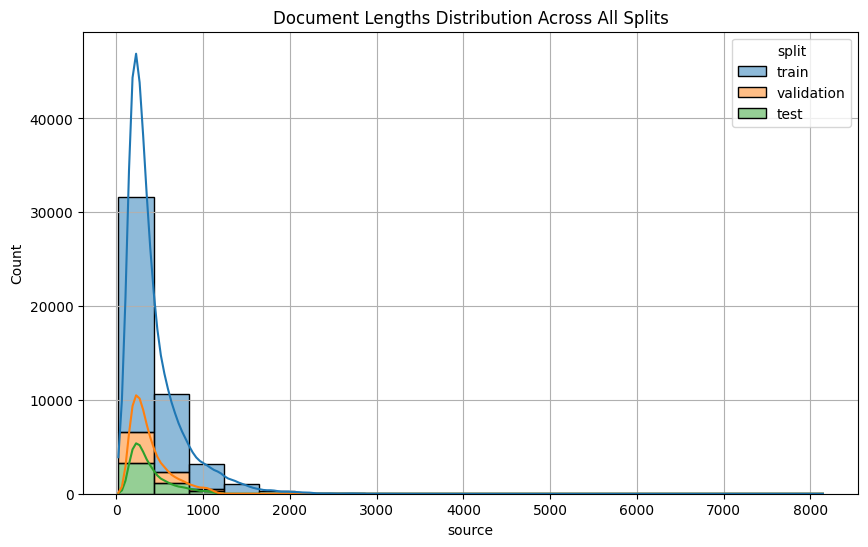

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=length_stat, x='source', hue='split', multiple='stack', kde=True, bins=20)
plt.title('Document Lengths Distribution Across All Splits')
plt.grid()

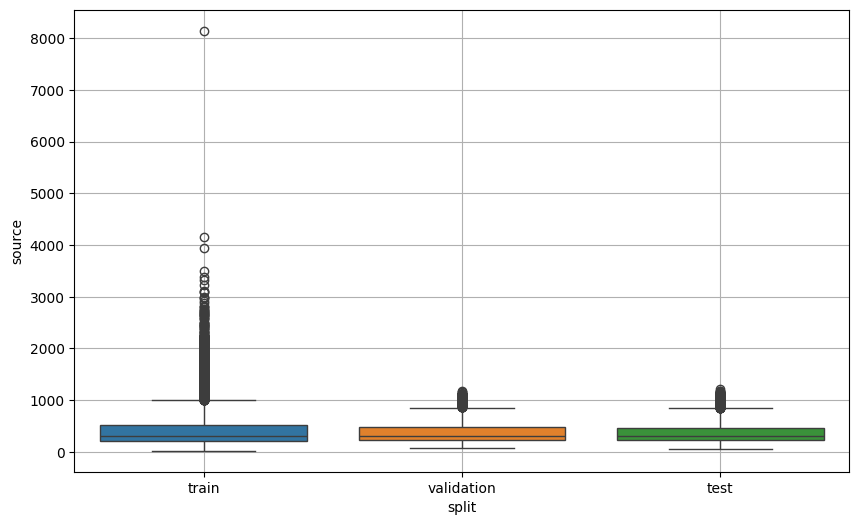

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=length_stat, x='split',y="source",hue='split')
plt.grid()

- Insights:
  1. distribution is right skewed
  2. the distribution of train,val,train are the same that indicate they are caming from the same source
  3. rare data points that have lenght greater than 2000 tokens length

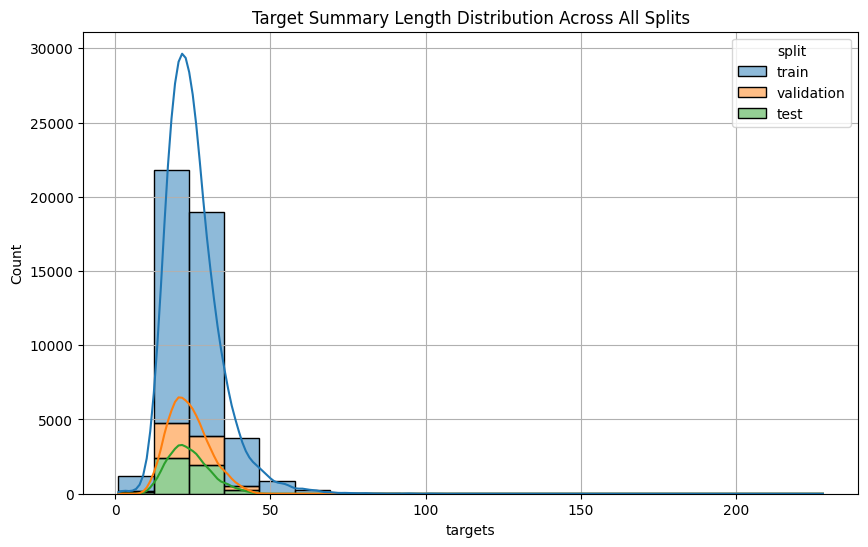

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=length_stat, x='targets', hue='split', multiple='stack', kde=True, bins=20)
plt.title('Target Summary Length Distribution Across All Splits')
plt.grid()

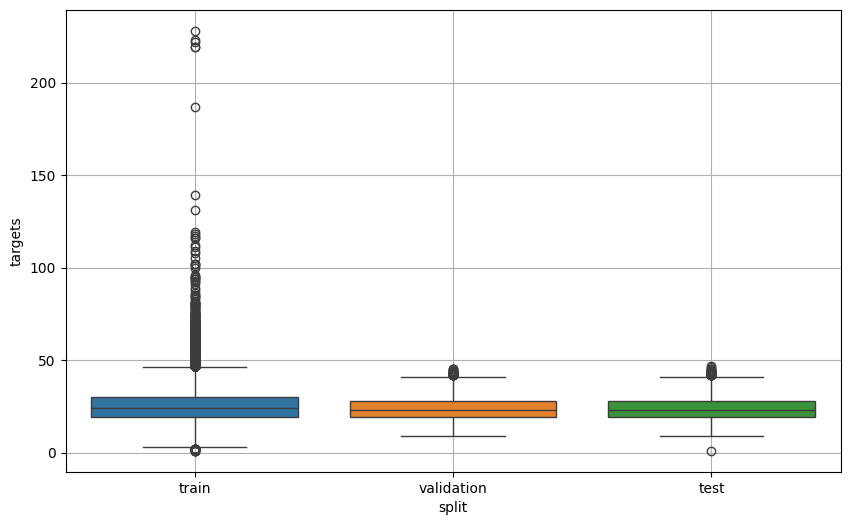

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=length_stat, x='split',y="targets",hue='split')
plt.grid()

- Right Skewed
- Most data points have 35-40 tokens in summary
- almost Identical distribution for the 3 splits

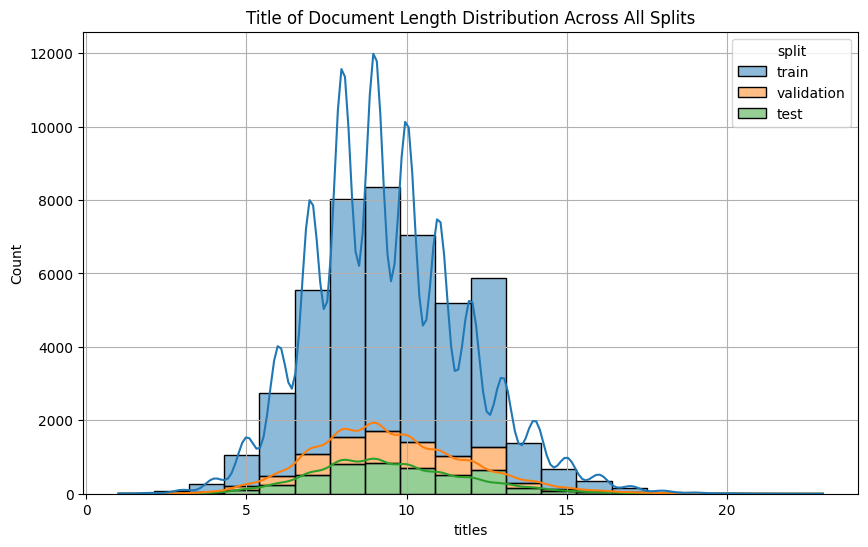

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=length_stat, x='titles', hue='split', multiple='stack', kde=True, bins=20)
plt.title('Title of Document Length Distribution Across All Splits')
plt.grid()

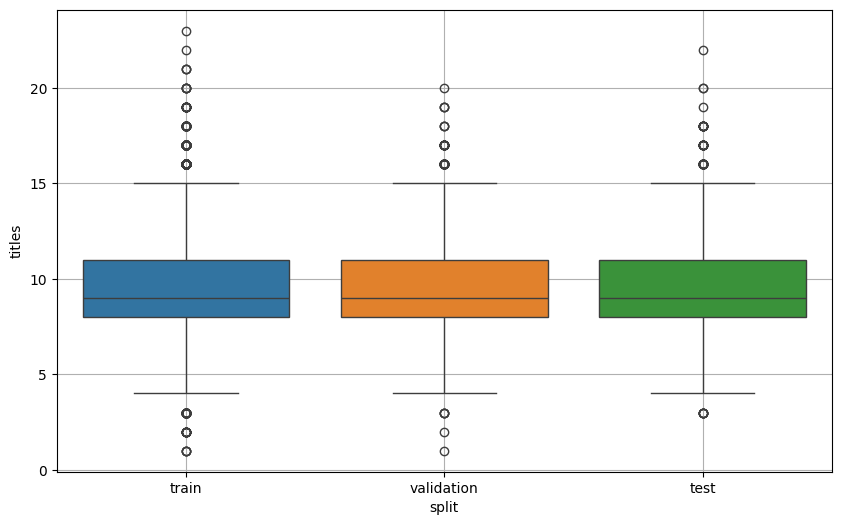

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=length_stat, x='split',y="titles",hue='split')
plt.grid()

- Insights:
 1. doesn't suffer from skeweness problem
 2. most artiles have 8-10 tokens length in title
 3. 50% of the data points have less than 10 tokens in the title

In [ ]:
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]+np.linspace(0.91,0.99,num=9).tolist()
length_stat.groupby('split').agg(
    min_length=('source', 'min'),
    max_length=('source', 'max'),
    **{f'{int(p * 100)}th_percentile': ('source', lambda x, p=p: np.percentile(x,p*100)) for p in percentiles}
)


,min_length,max_length,10th_percentile,20th_percentile,30th_percentile,40th_percentile,50th_percentile,60th_percentile,70th_percentile,80th_percentile,90th_percentile,91th_percentile,92th_percentile,93th_percentile,94th_percentile,95th_percentile,96th_percentile,97th_percentile,98th_percentile,99th_percentile
split,,,,,,,,,,,,,,,,,,,,
test,52,1213,170.0,205.0,239.0,272.0,312.0,362.0,427.0,530.4,701.0,726.0,753.96,780.84,805.0,845.6,883.96,922.44,996.48,1051.00
train,22,8144,141.0,185.0,223.0,265.0,313.0,374.0,462.0,607.0,877.5,926.0,980.00,1040.00,1105.0,1173.0,1243.00,1340.00,1462.00,1697.85
validation,75,1172,165.0,203.0,237.4,275.0,315.0,362.8,430.6,532.0,703.0,726.0,748.92,777.00,810.0,847.6,897.48,948.36,1000.00,1057.12


- 90% of the data points in training split have less than 1009.0 tokens
- 90% of the data points in test split have less than 808.2 tokens
- 90% of the data points in training split have less than 807.0 tokens

- difference between 80th and 90th in training split is really huge

In [ ]:
length_stat.groupby('split').agg(
    min_length=('titles', 'min'),
    max_length=('titles', 'max'),
    **{f'{int(p * 100)}th_percentile': ('titles', lambda x, p=p: np.percentile(x,p*100)) for p in percentiles}
)

,min_length,max_length,10th_percentile,20th_percentile,30th_percentile,40th_percentile,50th_percentile,60th_percentile,70th_percentile,80th_percentile,90th_percentile,91th_percentile,92th_percentile,93th_percentile,94th_percentile,95th_percentile,96th_percentile,97th_percentile,98th_percentile,99th_percentile
split,,,,,,,,,,,,,,,,,,,,
test,3,22,7.0,8.0,8.0,9.0,9.0,10.0,11.0,11.0,13.0,13.0,13.0,13.0,13.00,14.0,14.0,14.0,15.0,16.0
train,1,23,7.0,7.0,8.0,9.0,9.0,10.0,10.0,11.0,13.0,13.0,13.0,13.0,13.00,14.0,14.0,14.0,15.0,16.0
validation,1,20,7.0,7.0,8.0,9.0,9.0,10.0,11.0,11.0,13.0,13.0,13.0,13.0,13.72,14.0,14.0,14.0,15.0,16.0


In [ ]:
length_stat.groupby('split').agg(
    min_length=('targets', 'min'),
    max_length=('targets', 'max'),
    **{f'{int(p * 100)}th_percentile': ('targets', lambda x, p=p: np.percentile(x,p*100)) for p in percentiles}
)

,min_length,max_length,10th_percentile,20th_percentile,30th_percentile,40th_percentile,50th_percentile,60th_percentile,70th_percentile,80th_percentile,90th_percentile,91th_percentile,92th_percentile,93th_percentile,94th_percentile,95th_percentile,96th_percentile,97th_percentile,98th_percentile,99th_percentile
split,,,,,,,,,,,,,,,,,,,,
test,1,47,16.0,18.0,20.0,21.0,23.0,25.0,27.0,29.0,33.0,33.0,34.0,35.0,35.0,36.0,37.0,38.0,39.0,41.0
train,1,228,16.0,18.0,20.0,22.0,24.0,26.0,28.0,31.0,37.0,38.0,39.0,40.0,41.0,43.0,45.0,47.0,50.0,57.0
validation,9,45,16.0,18.0,20.0,21.0,23.0,25.0,27.0,29.0,33.0,33.0,34.0,34.0,35.0,36.0,37.0,38.0,39.0,41.0


- 90% of data points have less than 41 tokens as summary

In [ ]:
def get_confidence_of_ith_percentile_by_bootstrapping(data,p=90):
    sample_size=200
    percentiles=[]
    for i in range(0,sample_size):
        samples=random.sample((data),len(data))     ## taking 50000 random lengths from data
        samples2=random.choices(samples,k=int(len(data)*0.85))  ## taking 42579 samples ith replacement from above samples
        g=np.percentile(samples+samples2, p)
        percentiles.append(g)
    mean = np.round(np.mean(percentiles),3)
    std = np.round(np.std(percentiles),3)

    left_limit = np.round(mean - 2*(std/np.sqrt(sample_size)), 3)
    right_limit = np.round(mean + 2*(std/np.sqrt(sample_size)), 3)
    return {"mean":mean,
            "std":std,
            "left_limit":left_limit,
            "right_limit":right_limit}



In [ ]:
t = list(length_stat['source'])
get_confidence_of_ith_percentile_by_bootstrapping(t)

{'mean': 830.863, 'std': 2.88, 'left_limit': 830.456, 'right_limit': 831.27}

In [ ]:
get_confidence_of_ith_percentile_by_bootstrapping(length_stat['targets'].tolist())

{'mean': 36.0, 'std': 0.0, 'left_limit': 36.0, 'right_limit': 36.0}

In [ ]:
get_confidence_of_ith_percentile_by_bootstrapping(length_stat['source'].tolist(),p=95)

{'mean': 1095.063,
 'std': 2.968,
 'left_limit': 1094.643,
 'right_limit': 1095.483}

In [ ]:
get_confidence_of_ith_percentile_by_bootstrapping(length_stat['targets'].tolist(),p=95)

{'mean': 41.0, 'std': 0.0, 'left_limit': 41.0, 'right_limit': 41.0}

In [ ]:
get_confidence_of_ith_percentile_by_bootstrapping(length_stat['source'].tolist(),p=80)

{'mean': 587.942, 'std': 1.487, 'left_limit': 587.732, 'right_limit': 588.152}

1. using cutoff for input document to be 955 when considering 90th percentile
2. using cutoff for summary length to be 40 token when considering 90th percentile

here i have treated all subsets as whole due to the closed distribution of each subset and to get general cutoff for all subsets



## 2.2 Get English words

In [ ]:
def get_english_words(text):
    return re.findall(r'[a-zA-Z]+',text)
def extract_english_words_from_batch(batch,column,table:Counter):
    for doc in batch[column]:
        english_words = get_english_words(doc)
        if english_words:
          english_words = [word.lower() for word in english_words]
          table.update(english_words)

def extract_english_words_hf(ds):
    meta_data = ds.column_names
    extracted_data = {split:{} for split in meta_data}
    for split,col_names in meta_data.items():
        for col in col_names:
            table = Counter()
            _ = ds[split].map(extract_english_words_from_batch,
                              fn_kwargs={'table':table,
                                          "column":col})
            extracted_data[split][col]=dict(table)
    return extracted_data

In [ ]:
extracted_english_words = extract_english_words_hf(cleaned_data)

Map:   0%|          | 0/37516 [00:00<?, ? examples/s]

Map:   0%|          | 0/37516 [00:00<?, ? examples/s]

Map:   0%|          | 0/37516 [00:00<?, ? examples/s]

Map:   0%|          | 0/4689 [00:00<?, ? examples/s]

Map:   0%|          | 0/4689 [00:00<?, ? examples/s]

Map:   0%|          | 0/4689 [00:00<?, ? examples/s]

Map:   0%|          | 0/4689 [00:00<?, ? examples/s]

Map:   0%|          | 0/4689 [00:00<?, ? examples/s]

Map:   0%|          | 0/4689 [00:00<?, ? examples/s]

In [ ]:
english_words_df = pd.DataFrame.from_dict(extracted_english_words,orient='index')

In [ ]:
english_words_df

,source,targets,titles
train,"{'b': 4853, 'c': 4212, 't': 4656, 'r': 4297, '...","{'m': 74, 'c': 84, 'l': 88, 'a': 184, 'r': 123...","{'m': 20, 'h': 16, 'f': 7, 'r': 12, 'e': 18, '..."
validation,"{'b': 291, 'c': 296, 'f': 107, 'u': 183, 't': ...","{'a': 16, 'h': 11, 'n': 9, 't': 15, 'e': 26, '...","{'m': 3, 'h': 3, 's': 4, 'c': 2, 'i': 4, 'a': ..."
test,"{'l': 205, 'i': 295, 'v': 64, 'e': 552, 'a': 4...","{'s': 11, 'l': 7, 'o': 13, 'p': 3, 'e': 13, 't...","{'b': 1, 'p': 1, 'm': 3, 'h': 2, 'o': 2, 't': ..."


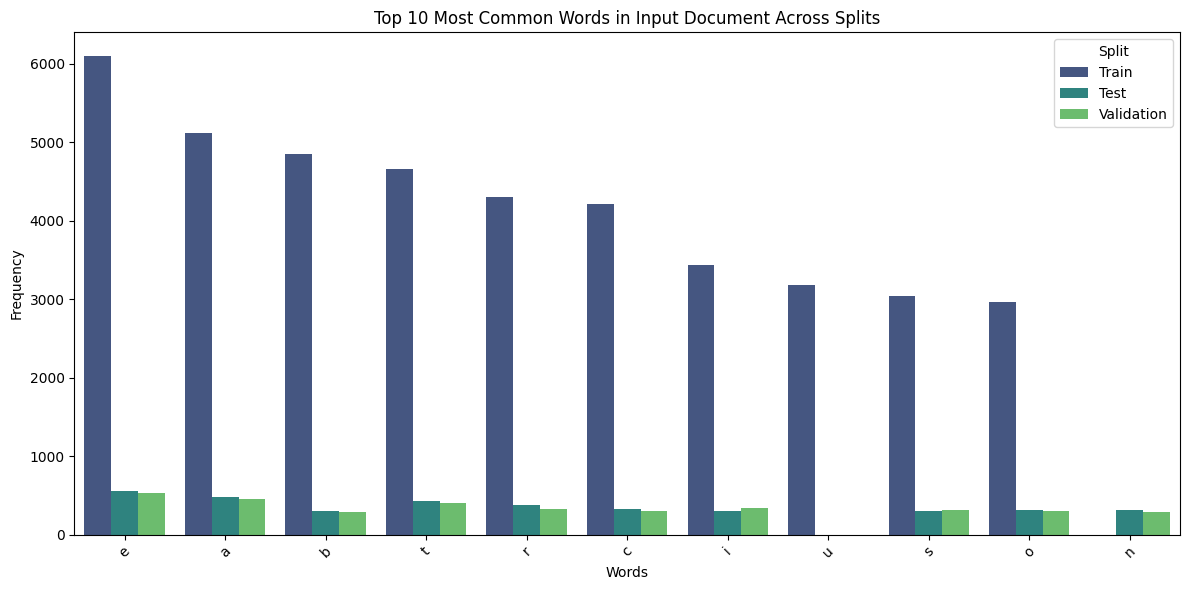

In [ ]:

validation_top_10 = Counter(english_words_df['source']['validation']).most_common(10)
train_top_10 = Counter(english_words_df['source']['train']).most_common(10)
test_top_10 = Counter(english_words_df['source']['test']).most_common(10)

# Convert to DataFrame for easy plotting
validation_df = pd.DataFrame(validation_top_10, columns=['Word', 'Validation'])
train_df = pd.DataFrame(train_top_10, columns=['Word', 'Train'])
test_df = pd.DataFrame(test_top_10, columns=['Word', 'Test'])

# Merge dataframes on 'Word' column
merged_df = pd.merge(validation_df, train_df, on='Word', how='outer')
merged_df = pd.merge(merged_df, test_df, on='Word', how='outer')

# Fill NaN with 0 (if some words don't appear in all splits)
merged_df.fillna(0, inplace=True)

# Melt the DataFrame into long format for seaborn
melted_df = merged_df.melt(id_vars='Word', value_vars=[ 'Train','Validation', 'Test'],
                           var_name='Split', value_name='Frequency')
melted_df = melted_df.sort_values(by=['Frequency'],ascending=False)
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='Word', y='Frequency', hue='Split', palette='viridis')

plt.title("Top 10 Most Common Words in Input Document Across Splits")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


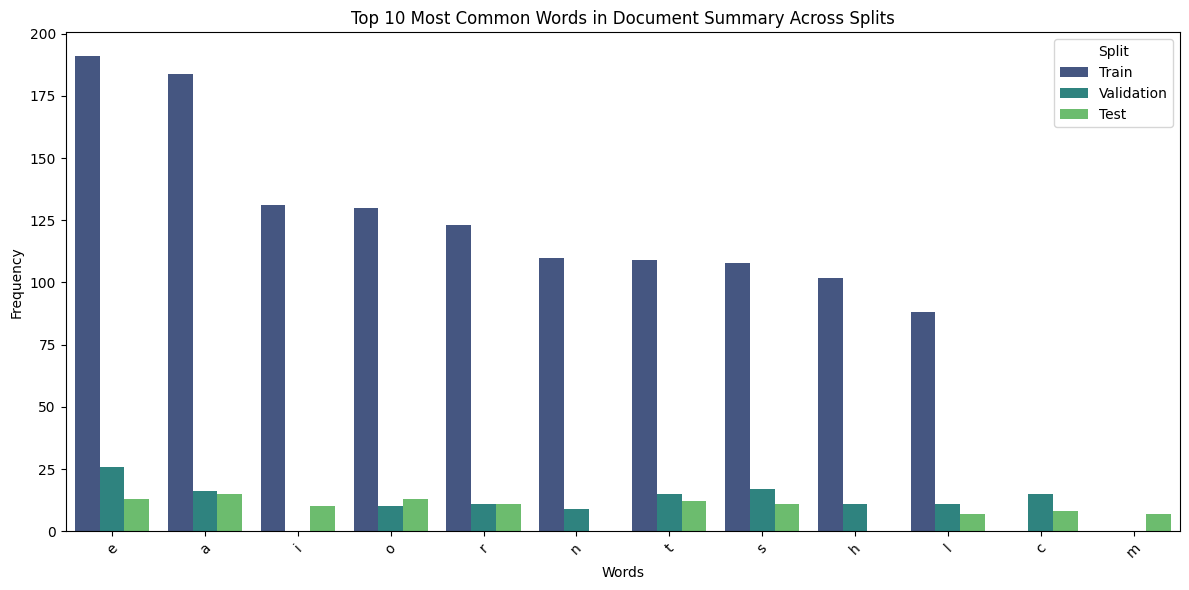

In [ ]:

validation_top_10 = Counter(english_words_df['targets']['validation']).most_common(10)
train_top_10 = Counter(english_words_df['targets']['train']).most_common(10)
test_top_10 = Counter(english_words_df['targets']['test']).most_common(10)

# Convert to DataFrame for easy plotting
validation_df = pd.DataFrame(validation_top_10, columns=['Word', 'Validation'])
train_df = pd.DataFrame(train_top_10, columns=['Word', 'Train'])
test_df = pd.DataFrame(test_top_10, columns=['Word', 'Test'])

# Merge dataframes on 'Word' column
merged_df = pd.merge(validation_df, train_df, on='Word', how='outer')
merged_df = pd.merge(merged_df, test_df, on='Word', how='outer')

# Fill NaN with 0 (if some words don't appear in all splits)
merged_df.fillna(0, inplace=True)

# Melt the DataFrame into long format for seaborn
melted_df = merged_df.melt(id_vars='Word', value_vars=[ 'Train','Validation', 'Test'],
                           var_name='Split', value_name='Frequency')
melted_df = melted_df.sort_values(by=['Frequency'],ascending=False)
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='Word', y='Frequency', hue='Split', palette='viridis')

plt.title("Top 10 Most Common Words in Document Summary Across Splits")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


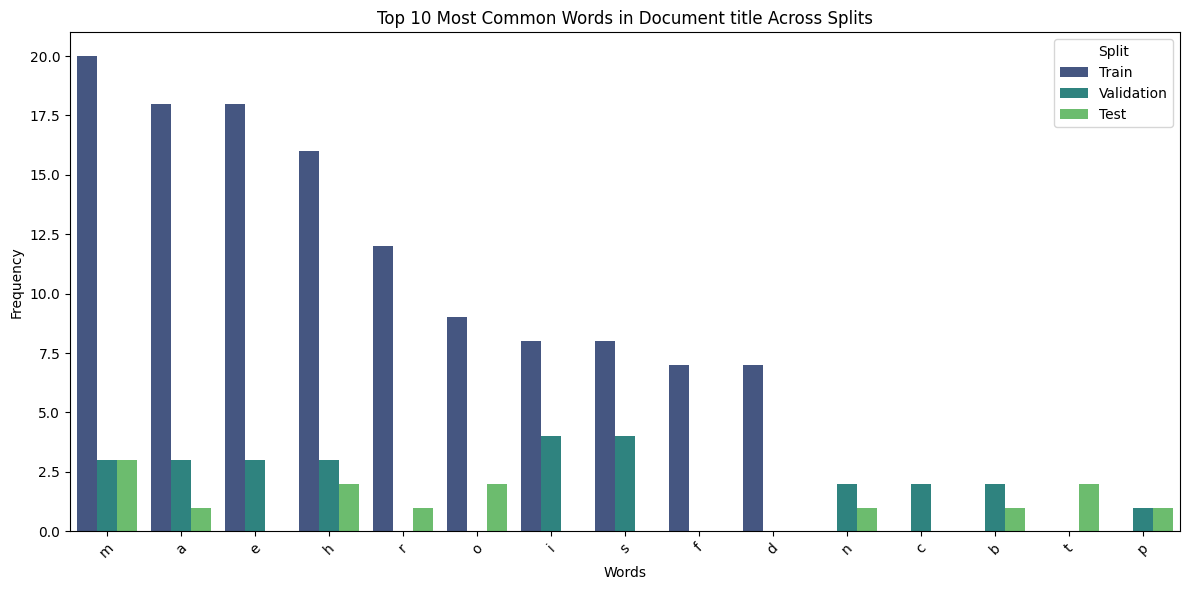

In [ ]:

validation_top_10 = Counter(english_words_df['titles']['validation']).most_common(10)
train_top_10 = Counter(english_words_df['titles']['train']).most_common(10)
test_top_10 = Counter(english_words_df['titles']['test']).most_common(10)

# Convert to DataFrame for easy plotting
validation_df = pd.DataFrame(validation_top_10, columns=['Word', 'Validation'])
train_df = pd.DataFrame(train_top_10, columns=['Word', 'Train'])
test_df = pd.DataFrame(test_top_10, columns=['Word', 'Test'])

# Merge dataframes on 'Word' column
merged_df = pd.merge(validation_df, train_df, on='Word', how='outer')
merged_df = pd.merge(merged_df, test_df, on='Word', how='outer')

# Fill NaN with 0 (if some words don't appear in all splits)
merged_df.fillna(0, inplace=True)

# Melt the DataFrame into long format for seaborn
melted_df = merged_df.melt(id_vars='Word', value_vars=[ 'Train','Validation', 'Test'],
                           var_name='Split', value_name='Frequency')
melted_df = melted_df.sort_values(by=['Frequency'],ascending=False)
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='Word', y='Frequency', hue='Split', palette='viridis')

plt.title("Top 10 Most Common Words in Document title Across Splits")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Insights:
- no full words in our dataset just English characters
- most of the repeated character in input doc and target summary is `e`
- character `u` in input documents doesn't appear in val,test splits
- character `m`&`n` are rarely appear in input and summary but `m` is appearing frequently in title of the documents

## 2.3 Word Cloud

In [ ]:
! git clone https://github.com/mohataher/arabic-stop-words.git

Cloning into 'arabic-stop-words'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 48 (delta 3), reused 2 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (48/48), 25.35 KiB | 8.45 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
with open('/content/arabic-stop-words/list.txt') as file:
    ar_stop_words = file.readlines()
ar_stop_words = set([dediac_ar(token.strip().replace('\n','')) for token in ar_stop_words]+list(punctuation))

In [ ]:
t = cleaned_data['train'][0]['source']

In [ ]:
mle_egy = MLEDisambiguator.pretrained('calima-egy-r13')

In [ ]:
mle_msa = MLEDisambiguator.pretrained("calima-msa-r13")

In [ ]:
mle_egy.tok_feats()

frozenset({'bwtok'})

In [ ]:
mle_msa.tok_feats()

frozenset({'atbseg',
           'atbtok',
           'bwtok',
           'd1seg',
           'd1tok',
           'd2seg',
           'd2tok',
           'd3seg',
           'd3tok'})

In [ ]:
tokenizer = MorphologicalTokenizer(mle_egy, scheme='bwtok',split=True)
tokens = tokenizer.tokenize(simple_word_tokenize(t))

In [ ]:
tokenizer2 = MorphologicalTokenizer(mle_msa, scheme='d3tok',split=True)
tokens2 = tokenizer2.tokenize(simple_word_tokenize(t))

In [ ]:
stem_tokens = [token for token in tokens if not token.startswith('+') and not token.endswith('+')]
stem_tokens2 = [token for token in tokens2 if not token.startswith('+') and not token.endswith('+')]

In [ ]:
meanful_tokens = [token for  token in stem_tokens if not token in ar_stop_words]
meanful_tokens2 = [token for  token in stem_tokens2 if not token in ar_stop_words and not token.isdigit()]

In [ ]:
len(meanful_tokens)

377

In [ ]:
len(meanful_tokens2)

372

In [ ]:
len(stem_tokens)

584

In [ ]:
FONT_PATH = "/content/arial.ttf"

In [ ]:
dmp = diff_match_patch()
t2 = " ".join(meanful_tokens2)
diffs = dmp.diff_main( cleaned_data['train'][0]['source'],t2)
html = dmp.diff_prettyHtml(diffs)
display(HTML(html))

In [ ]:
def column_to_wordcloud(df, column, font_file, stopwords=None):
    """
    Parameters:
      df: the dataframe that contains the column
      column: the name of the column that contains the text
      font_file: the path to the font file for Arabic characters
      stopwords: a list of words to exclude from the wordcloud

    Outputs:
        None. The function only displays the word cloud image.
    """
    text = " ".join(arabic_reshaper.reshape(t) for t in df[column].dropna())
    # create and display the wordcloud
    wordcloud = WordCloud(font_path=font_file,
                          width = 3500,
                          height = 2000,
                          random_state=1,
                          min_font_size =10,
                          background_color='white',
                          # colormap='Set2',
                          collocations=False,
                          stopwords = stopwords).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
cleaned_data['train'].set_format('pandas')

In [ ]:
tqdm.pandas()

In [ ]:
df = cleaned_data['train'][:]
for i,row in df.iterrows():
    print(row.index.tolist())
    break

['source', 'targets', 'titles']


In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("StopWordsRemoval").getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
df_spark = spark.createDataFrame(cleaned_data['train'].to_pandas())

# Define the stop word removal function as a UDF
@udf(StringType())
def remove_stop_words_udf(text):
    tokens = simple_word_tokenize(text)
    morph_tokens = tokenizer2.tokenize(tokens)

    # Filter tokens in parallel-like conditions using list comprehensions (PySpark will handle parallelism)
    stem_tokens = [token for token in morph_tokens if not token.startswith('+') and not token.endswith('+')]
    meaningful_tokens = [token for token in stem_tokens if not token in ar_stop_words and not token.isdigit()]

    return " ".join(meaningful_tokens)

In [ ]:
# Apply the UDF to each column in the DataFrame
for col in df_spark.columns:
    df_spark = df_spark.withColumn(col, remove_stop_words_udf(df_spark[col]))

In [ ]:
df_cleaned = df_spark.toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_cleaned.to_csv('/content/drive/MyDrive/Arabic-Text-Summarization/cleaned.csv')

In [ ]:
def filter_token(token):
    # Filtering out tokens based on conditions
    if  not token.startswith('+') and \
        not token.endswith('+') and \
        token not in ar_stop_words  and \
        not token.isdigit():
        return token
    return None

def remove_stop_words(text,tokenizer):
    # sequential tasks so will be treated as a unit
    tokens= simple_word_tokenize(text)
    morph_tokens = tokenizer.tokenize(tokens)

    # Parallelizing the stemming and stop word removal
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the parallel task of filtering the tokens
        stem_futures = {executor.submit(filter_token, token): token for token in morph_tokens}

        # Collect the meaningful tokens
        meaningful_tokens = [future.result() for future in concurrent.futures.as_completed(stem_futures) if future.result()]

    return " ".join(meaningful_tokens)
def handle_row_stop_word_removal(row,tokenizer):
    # this code must be parellelized
    columns = row.index.tolist()
    # results = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
      results = {col:executor.submit(remove_stop_words,row[col],tokenizer) for col in columns}

    for col,clean_text in results.items():
        row[col] = clean_text.result()
    return row
df = cleaned_data['train'][:]
to_visz_df = df.iloc[:10000,:].progress_apply(handle_row_stop_word_removal,axis=1,args=(tokenizer2,))

  3%|▎         | 270/10000 [05:52<3:31:34,  1.30s/it]


KeyboardInterrupt: 

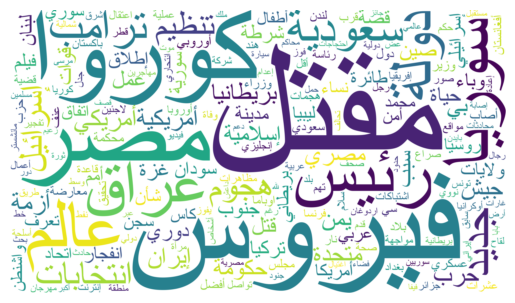

In [ ]:
column_to_wordcloud(to_visz_df,column='titles',font_file=FONT_PATH)

## 2.4 POS

In [ ]:
cleaned_data['train'].reset_format()

In [ ]:
def seperate_by_space(batch):
    new_title = " ".join(simple_word_tokenize(batch['titles']))
    new_source = " ".join(simple_word_tokenize(batch['source']))
    new_target = " ".join(simple_word_tokenize(batch['targets']))
    return {
        "titles":new_title,
        "source":new_source,
        "targets":new_target
    }
ready_ds = cleaned_data.map(seperate_by_space)

In [ ]:
def process_batch_pos(batch,table, tagger, col):
    # Tokenize the entire batch at once
    all_tokens = [doc.split() for doc in batch[col]]

    # Flatten the token lists to process all at once
    flattened_tokens = [token for tokens in all_tokens for token in tokens]

    # Tag the entire flattened list of tokens at once (instead of per document)
    tagged_tokens = tagger.tag(flattened_tokens)
    # update table
    table.update(tagged_tokens)

def process_hf_dataset_pos(ds, tagger):
    meta_data = ds.column_names
    pos_data = {split: {} for split in meta_data}

    for split, col_names in meta_data.items():
        for col in col_names:
            pos_table = Counter()
            # Using the map function to apply the process_batch_pos function
            _ = ds[split].map(
                lambda batch: process_batch_pos(batch,pos_table, tagger, col),
                # batched=True,
                # batch_size=64
            )


            # Store the final pos_table in pos_data
            pos_data[split][col] = pos_table

    return pos_data

In [ ]:
mle_msa = MLEDisambiguator.pretrained("calima-msa-r13")
tagger = DefaultTagger(mle, 'pos')

In [ ]:
subset = DatasetDict({"train":cleaned_data['train'].select(range(1000)),
                      "validation":cleaned_data['validation'],
                      "test":cleaned_data['test']})

In [ ]:
pos_data = process_hf_dataset_pos(subset,tagger)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

KeyboardInterrupt: 